In [312]:
%matplotlib inline

In [313]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')


In [314]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [315]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-09-03,0,0,0,0,0,שלילי,No,זכר,Other
1,2020-09-03,0,0,0,0,0,שלילי,No,זכר,Other
2,2020-09-03,0,0,0,0,0,שלילי,No,זכר,Other
3,2020-09-03,0,0,0,0,0,שלילי,NaN,זכר,Other
4,2020-09-03,0,0,0,0,0,שלילי,No,נקבה,Other


In [316]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [317]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [318]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [320]:
bdi.head()

,test_date,result_date,corona_result,lab_id,test_for_corona_diagnosis,is_first_Test,orig_test_date
0,2020-03-18,2020-03-18,חיובי,32,1,Yes,NaT
1,2020-03-18,2020-03-18,חיובי,1,1,Yes,NaT
2,2020-03-20,2020-03-20,שלילי,4,1,No,NaT
3,2020-03-20,2020-03-20,שלילי,4,1,No,NaT
4,2020-03-20,2020-03-20,שלילי,4,1,Yes,NaT


In [321]:
bdi.shape

(2564190, 7)

In [322]:
bdi.corona_result.value_counts()

שלילי               2344637
חיובי                170779
לא בוצע/פסול 999      25443
חיובי גבולי           22308
בעבודה                  625
לא ודאי                 398
Name: corona_result, dtype: int64

In [323]:
niv.corona_result.value_counts()

שלילי    1432112
חיובי     100401
אחר        20020
Name: corona_result, dtype: int64

In [324]:
niv.test_indication.value_counts()

Other                     1456167
Contact with confirmed      69916
Abroad                      26450
Name: test_indication, dtype: int64

In [325]:
niv.age_60_and_above.value_counts()

No     918152
Yes    137722
Name: age_60_and_above, dtype: int64

In [326]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [327]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [328]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [329]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


In [330]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,6,6,17,12.833333,13,12
1,3,11061,2,112,16.665582,17,33183
2,4,5081,2,114,21.462114,21,20324
3,5,3127,2,106,24.647905,25,15635
4,6,1786,6,96,27.668533,27,10716
5,7,1063,8,108,30.398871,30,7441
6,8,597,3,103,33.475712,33,4776
7,9,357,3,78,35.700280,35,3213
8,10,573,5,106,41.130890,41,5730


In [331]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

,index,total_tests_count
0,size,23651.000000
1,min,2.000000
2,max,12.000000
3,mean,4.320156
4,median,4.000000


In [332]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
9432,114,4,60+,זכר,Other
12342,112,3,30-39,זכר,Contact with confirmed
9304,111,4,20-29,זכר,Other
1600,108,7,40-49,נקבה,Contact with confirmed
6311,106,5,30-39,זכר,Contact with confirmed
23175,106,10+,0-19,נקבה,Contact with confirmed
9696,105,4,30-39,נקבה,Other
456,103,8,50-59,נקבה,Contact with confirmed
20936,103,3,0-19,זכר,Abroad
23273,100,10+,60+,זכר,Contact with confirmed


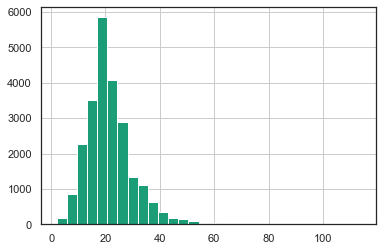

In [333]:
rec.days_between_pos_and_neg.hist(bins=30)

In [334]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-09-02,58001,28137,8290,2187
1,2020-09-01,55504,27455,9175,2003
2,2020-08-31,51971,27185,8223,2546
3,2020-08-30,49218,26041,7943,3081
4,2020-08-29,45904,23745,4234,1080


In [335]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [336]:
niv.age_60_and_above.value_counts()

No     918152
Yes    137722
Name: age_60_and_above, dtype: int64

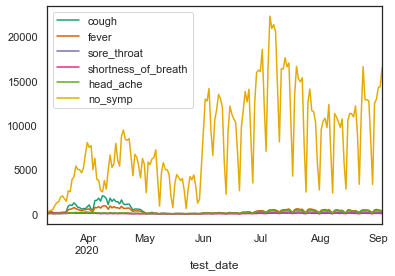

In [337]:
niv.groupby('test_date')[symptom_cols].sum().plot()

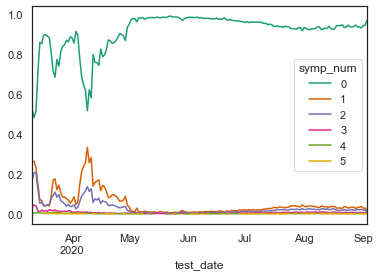

In [338]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

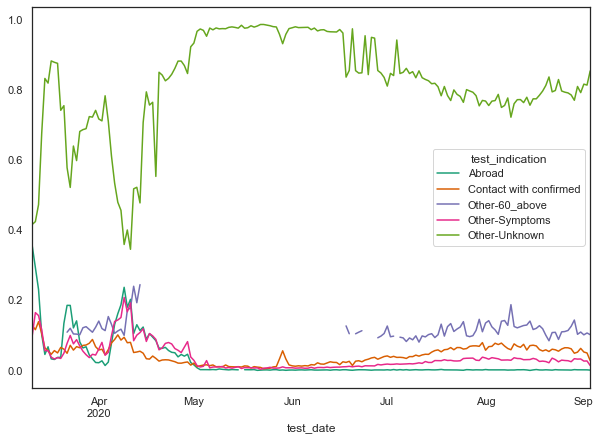

In [339]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

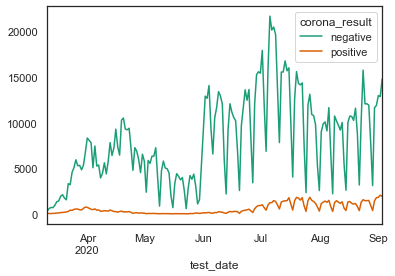

In [340]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [341]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

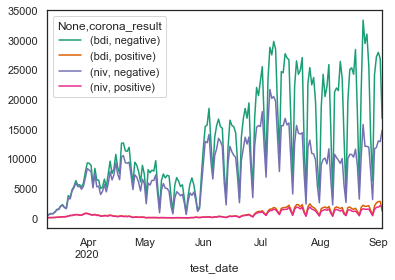

In [345]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

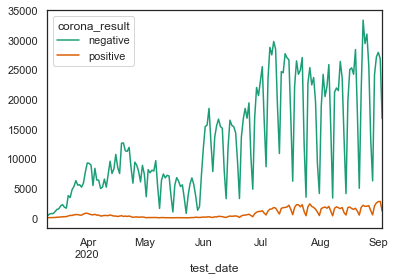

In [346]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [347]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-03-11,NaN,17.0,319.0,18.0,1.0
2020-05-09,59.0,NaN,1583.0,12.0,NaN
2020-05-14,126.0,2.0,7057.0,19.0,NaN
2020-05-15,58.0,NaN,3734.0,10.0,NaN
2020-05-16,45.0,NaN,989.0,5.0,NaN
2020-05-17,109.0,NaN,5508.0,17.0,NaN
2020-05-20,71.0,NaN,5286.0,19.0,NaN
2020-05-23,40.0,NaN,750.0,3.0,NaN
2020-05-24,94.0,NaN,3713.0,6.0,NaN


In [348]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-08-30,343.0,1.0,24174.0,2022.0,NaN
2020-08-31,352.0,1.0,27177.0,2523.0,NaN
2020-09-01,523.0,NaN,27935.0,2732.0,NaN
2020-09-02,420.0,NaN,26858.0,2774.0,NaN
2020-09-03,239.0,1.0,16767.0,1144.0,NaN


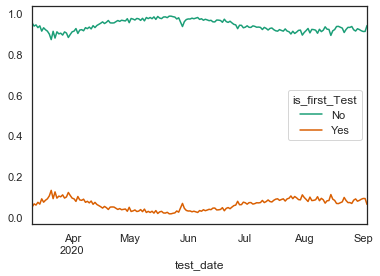

In [349]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

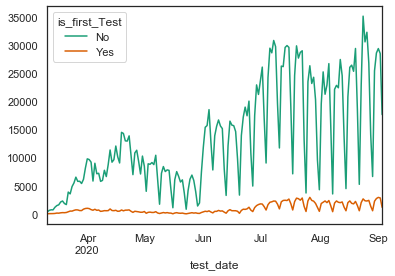

In [350]:
ti.plot()

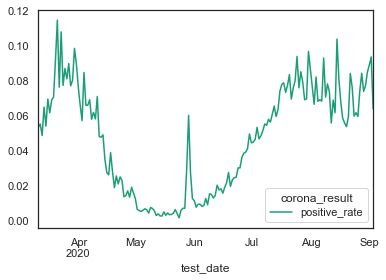

In [351]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [352]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-08-30,25396,2249
2020-08-31,28560,2726
2020-09-01,29347,2929
2020-09-02,28467,2830
2020-09-03,17627,1161


In [353]:
ti.Yes.sum() + ti.No.sum()

2564190

In [354]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [355]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [356]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [357]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&
          (bdi.corona_result.isin(['positive', 'negative'])) 
          ]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [358]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [359]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,medium,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,76,35.5,48.0,17.3,15,20.0,63.0,15.3,69,...,47.0,16.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
1,2020-03-12,98,38.8,50.0,18.0,15,20.0,63.0,15.3,91,...,49.0,17.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
2,2020-03-13,116,38.8,49.0,17.9,15,20.0,63.0,15.3,106,...,47.0,17.3,15,50.0,65.0,17.3,15,33.3,67.0,16.2
3,2020-03-14,154,40.9,47.0,18.2,15,0.0,70.0,7.4,145,...,46.0,17.4,15,50.0,65.0,17.3,15,20.0,76.0,10.3
4,2020-03-15,193,44.0,47.0,18.5,15,20.0,74.0,7.6,179,...,45.0,17.5,15,50.0,58.0,14.9,15,37.5,79.0,9.1


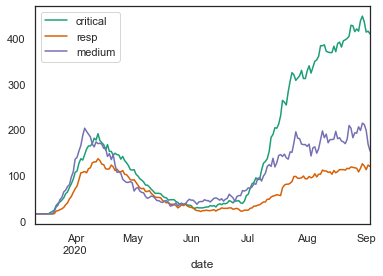

In [360]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [361]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,medium,negative,positive,positive_rate
0,2020-03-11,15,15,15,322,41,0.112948
1,2020-03-12,15,15,15,617,47,0.070783
2,2020-03-13,15,15,15,723,41,0.053665
3,2020-03-14,15,15,15,706,51,0.067371
4,2020-03-15,15,15,15,1030,110,0.096491


In [362]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [363]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


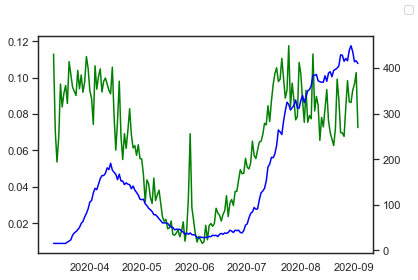

In [364]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [365]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [366]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [367]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

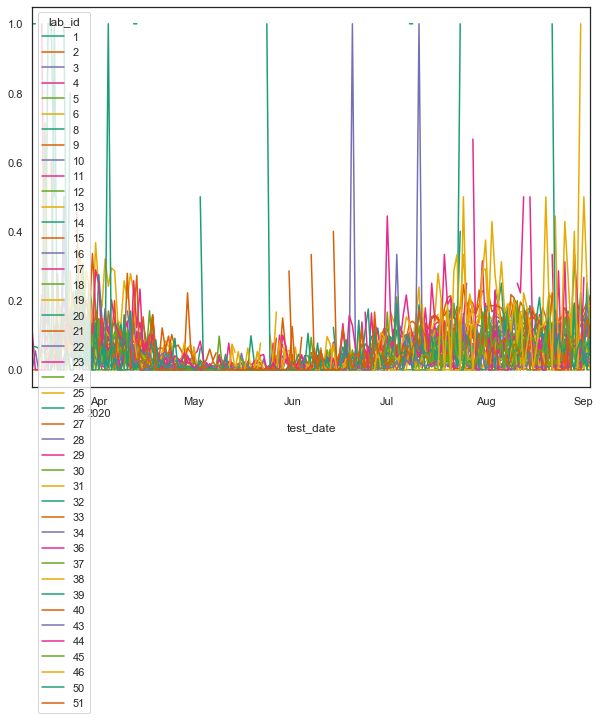

In [368]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative)
polab.positive_rate.unstack().plot(figsize=(10,7))

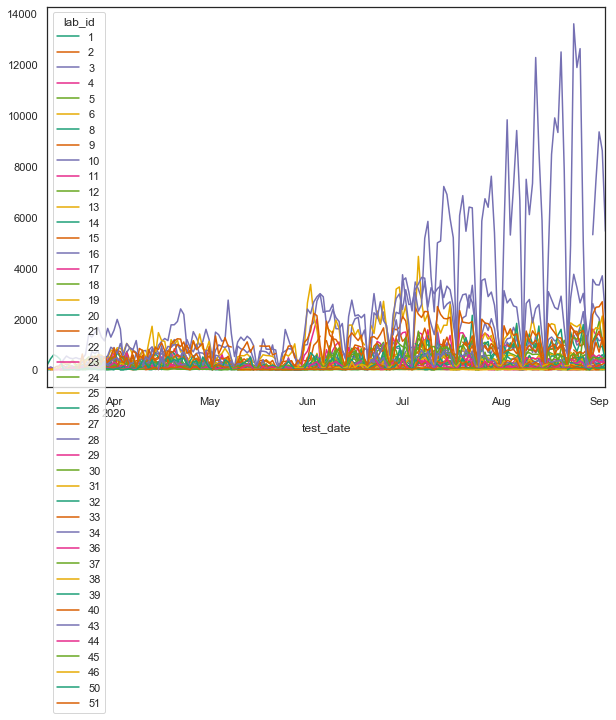

In [369]:
polab.total_tests.unstack().plot(figsize=(10,7))

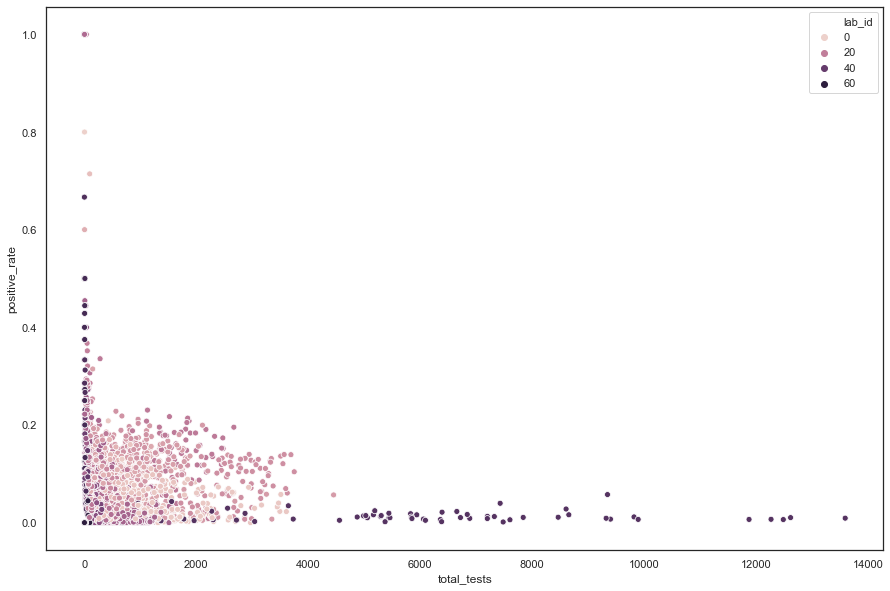

In [370]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [371]:
import altair as alt

In [372]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

In [373]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result,positive,negative,total_tests,positive_rate
lab_id,,,,
43,4834.0,366803.0,374894.0,0.7
16,20861.0,250953.0,272695.0,4.2
3,7776.0,233420.0,243010.0,1.7
13,13206.0,157762.0,175743.0,4.2
21,17414.0,139019.0,157873.0,6.3
10,6702.0,93349.0,103200.0,3.6
4,5426.0,95123.0,102205.0,2.9
27,1015.0,94499.0,95597.0,0.5
15,9138.0,80223.0,90636.0,5.7


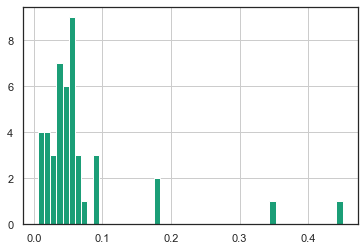

In [374]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [377]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:5]
top_5_labs

Int64Index([43, 16, 3, 13, 21], dtype='int64')

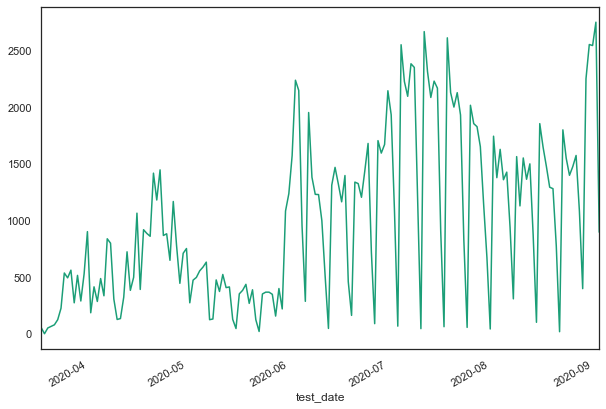

In [378]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

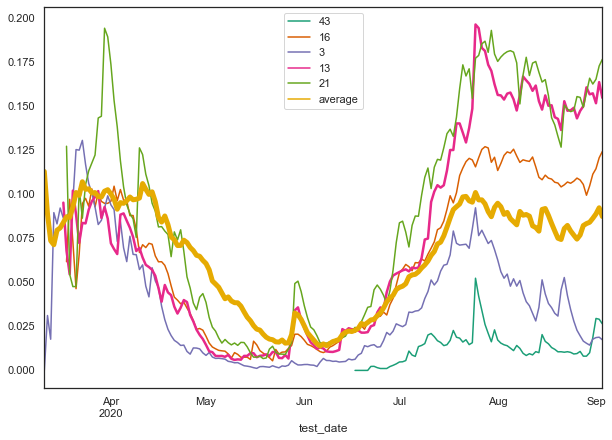

In [379]:
sns.set_palette(['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=[1.5,1.5,1.5,2.5,1.5,5][i])


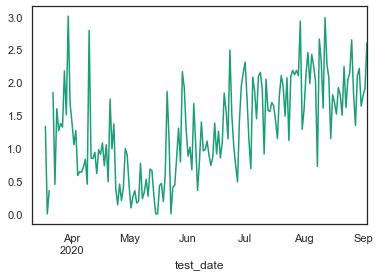

In [380]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [381]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.06575019791825099

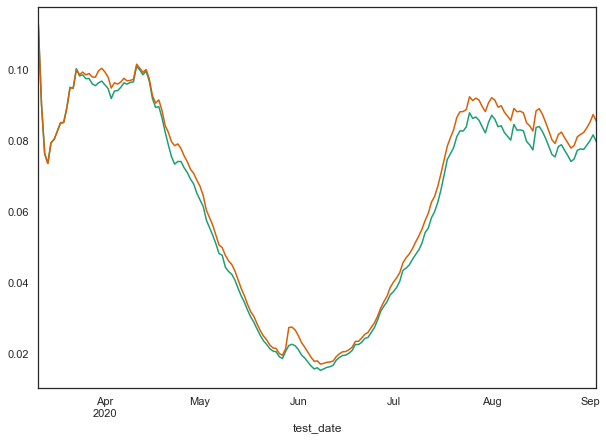

In [382]:
ax = (bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

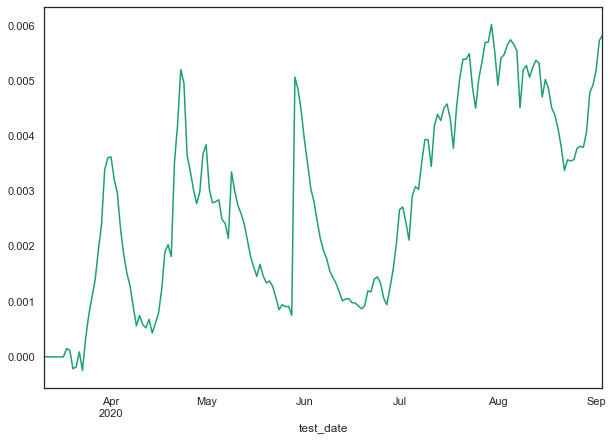

In [383]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

## Decseased 

In [396]:
last_dec = pd.read_csv(get_latest_file_glob('data/corona_deceased_ver*.csv.gz'), 
                       encoding='utf-8-sig', low_memory=False)
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 3.0]    0.210689
(3.0, 5.0]       0.089414
(5.0, 7.0]       0.108941
(7.0, 8.0]       0.043165
(8.0, 10.0]      0.094553
(10.0, 13.0]     0.096608
(13.0, 17.0]     0.089414
(17.0, 21.0]     0.087359
(21.0, 29.0]     0.091470
(29.0, 123.0]    0.081192
Name: qc, dtype: float64

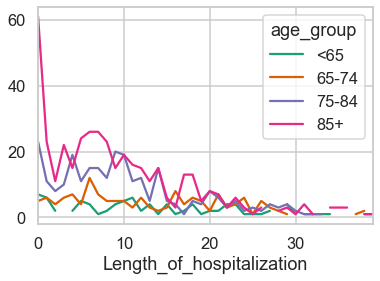

In [397]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

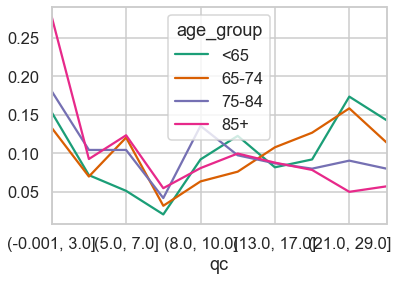

In [398]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [399]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.098664
1.0    0.047276
2.0    0.025694
3.0    0.039054
4.0    0.044193
5.0    0.045221
6.0    0.058582
7.0    0.050360
8.0    0.043165
9.0    0.045221
Name: Length_of_hospitalization, dtype: float64

In [400]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-36.0    0.001028
-25.0    0.001028
-21.0    0.002055
-16.0    0.001028
-15.0    0.001028
-14.0    0.002055
-12.0    0.001028
-11.0    0.001028
-9.0     0.001028
-8.0     0.001028
Name: Time_between_positive_and_hospitalization, dtype: float64

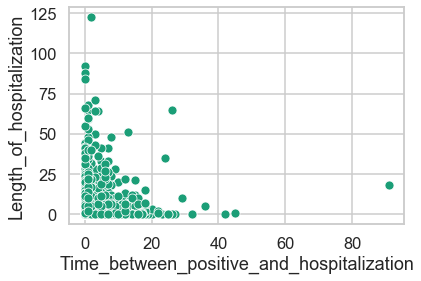

In [401]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

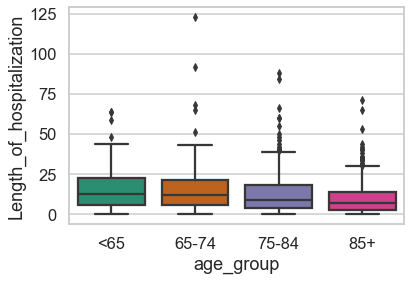

In [402]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [403]:
decs = []
for file in sorted(glob.glob('data/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    dec = pd.read_csv(file, 
                  encoding='utf-8-sig', low_memory=False)
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

,gender,age_group,Ventilated,Time_between_positive_and_hospitalization,Length_of_hospitalization,Time_between_positive_and_death,time,file
0,זכר,<65,1.0,2.0,20.0,22,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
203,נקבה,75-84,1.0,0.0,12.0,12,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
202,נקבה,85+,0.0,10.0,1.0,11,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
201,נקבה,85+,0.0,2.0,17.0,19,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz
200,זכר,85+,1.0,0.0,9.0,9,2020-06-16 12:09:51,data\corona_deceased_ver_001.csv.gz


In [404]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((12482, 8), (810, 8))

In [405]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

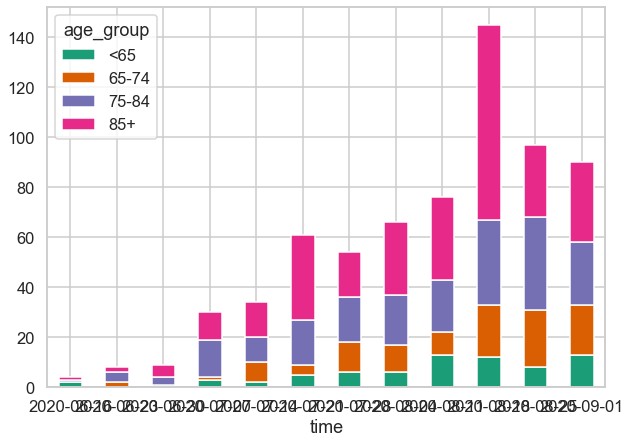

In [406]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

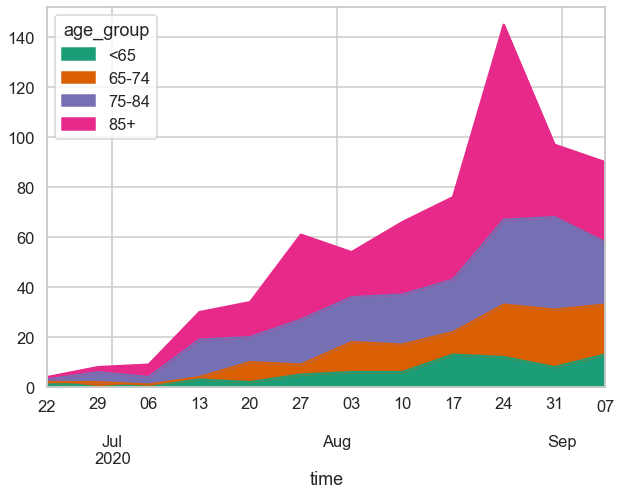

In [407]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

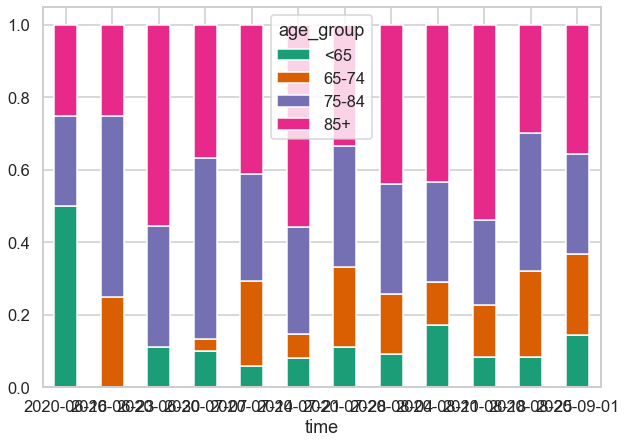

In [408]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [409]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


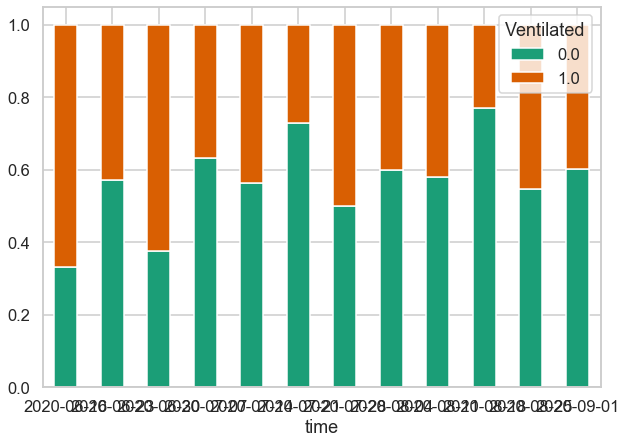

In [410]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

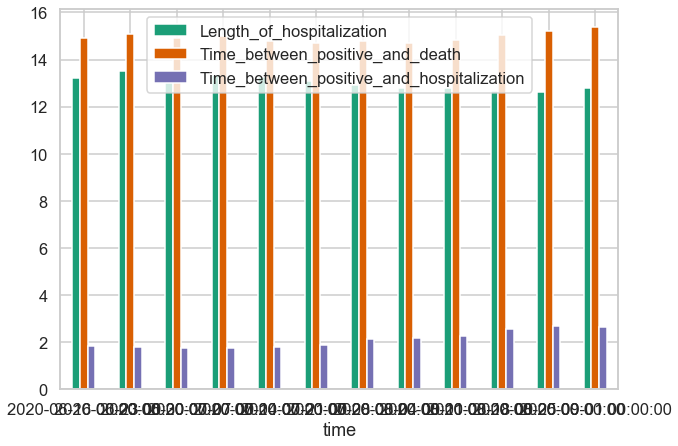

In [411]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


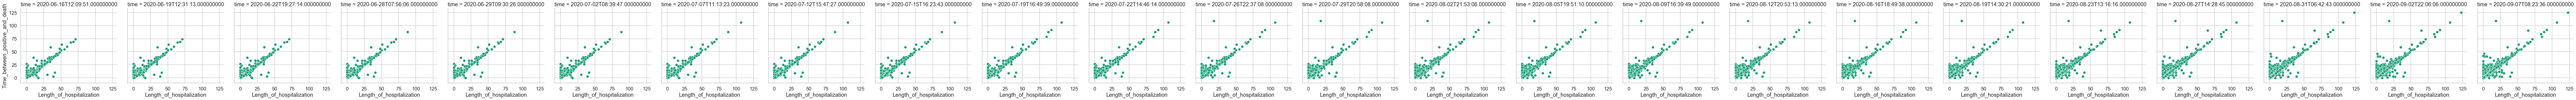

In [412]:
sns.relplot(data=decs, col='time', x='Length_of_hospitalization', y='Time_between_positive_and_death', kind='scatter')

In [413]:
hos.head().T

,0,1,2,3,4
date,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00
מאושפזים,76,98,116,154,193
אחוז נשים מאושפזות,35.5,38.8,38.8,40.9,44
גיל ממוצע מאושפזים,48,50,49,47,47
סטיית תקן גיל מאושפזים,17.3,18,17.9,18.2,18.5
resp,15,15,15,15,15
אחוז נשים מונשמות,20,20,20,0,20
גיל ממוצע מונשמים,63,63,63,70,74
סטיית תקן גיל מונשמים,15.3,15.3,15.3,7.4,7.6
חולים קל,69,91,106,145,179


In [414]:
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,19,9,40-49,זכר,Abroad
1,22,9,30-39,זכר,Contact with confirmed
2,26,9,30-39,זכר,Contact with confirmed
3,28,9,30-39,נקבה,Abroad
4,23,9,20-29,נקבה,Contact with confirmed


## Recovered

In [415]:
pd.read_csv('data/corona_recovered_ver_004.csv.gz', encoding='1255')

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,8.0,9,40-49,נקבה,Contact with confirmed
1,19.0,9,30-39,זכר,Contact with confirmed
2,33.0,9,60+,זכר,Abroad
3,24.0,9,30-39,זכר,Contact with confirmed
4,20.0,9,40-49,זכר,Abroad
...,...,...,...,...,...
6408,NaN,NaN,60+,זכר,Other
6409,NaN,NaN,60+,נקבה,Contact with confirmed
6410,NaN,NaN,60+,נקבה,Contact with confirmed
6411,NaN,NaN,60+,זכר,Abroad


In [416]:
recs = []
for file in sorted(glob.glob('data/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

data\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
data\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
data\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
data\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
data\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
data\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
data\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
data\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
data\corona_recovered_ver_0025.csv.gz 2020-07-02 08:39:47
data\corona_recovered_ver_0026.csv.gz 2020-07-07 11:13:23
data\corona_recovered_ver_0031.csv.gz 2020-07-12 15:47:27
data\corona_recover

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication,time,file,ver
4923,12.0,3,30-39,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4281,15.0,3,40-49,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4280,4.0,3,20-29,נקבה,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4279,13.0,3,50-59,זכר,Other,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4
4278,7.0,3,30-39,נקבה,Abroad,2020-05-30 14:05:58,data\corona_recovered_ver_004.csv.gz,4


In [417]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

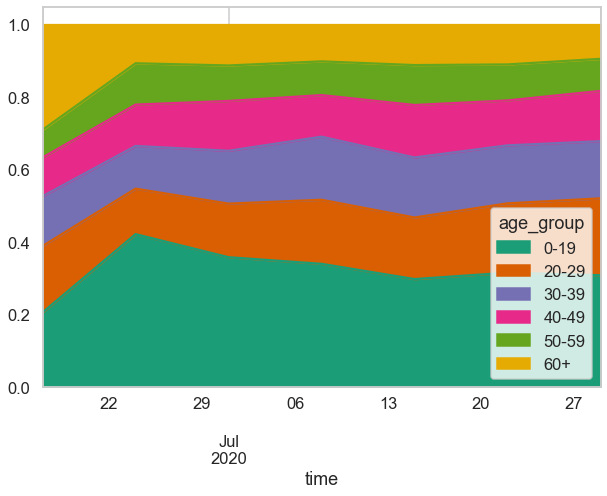

In [418]:
sns.set_style('whitegrid')
sns.set_context('talk')
rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [419]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='data', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

,first_week_day,last_week_day,age_group,gender,weekly_tests_num,weekly_newly_tested,weekly_cases,weekly_deceased
0,2020-03-15,2020-03-21,0-19,נקבה,916.0,879.0,40.0,0.0
1,2020-03-15,2020-03-21,0-19,לא ידוע,44.0,44.0,0.0,0.0
2,2020-03-15,2020-03-21,0-19,זכר,1103.0,1052.0,37.0,0.0
3,2020-03-15,2020-03-21,20-24,זכר,691.0,646.0,107.0,0.0
4,2020-03-15,2020-03-21,20-24,נקבה,640.0,619.0,37.0,0.0


In [420]:
ag.weekly_deceased.value_counts()

0.0     866
<15     196
26.0      3
22.0      2
15.0      2
19.0      2
21.0      1
35.0      1
23.0      1
20.0      1
33.0      1
31.0      1
27.0      1
18.0      1
16.0      1
Name: weekly_deceased, dtype: int64

In [421]:
ag.weekly_deceased.replace('<15','10').astype(int).plot()

ValueError: invalid literal for int() with base 10: '0.0'